# Applying Regression Techniques to Ames House Pricing WIP

In [141]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe

# pd.options.display.max_rows = None

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

## EDA

In [95]:
base_path = "./house-prices-advanced-regression-techniques"
original_train = pd.read_csv(f"{base_path}/train.csv")

In [96]:
def get_original_train_df() -> pd.DataFrame:
    return original_train.copy()

In [97]:
eda_train = get_original_train_df()
eda_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [98]:
print(eda_train.shape)

(1460, 81)


In [99]:
eda_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [100]:
eda_train.drop("Id", axis=1, inplace=True)

In [101]:
eda_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [102]:
px.histogram(eda_train, x="SalePrice", nbins=60, marginal="box")

In [103]:
categorical_columns = eda_train.select_dtypes(include=['object']).columns.tolist()
len(categorical_columns)

43

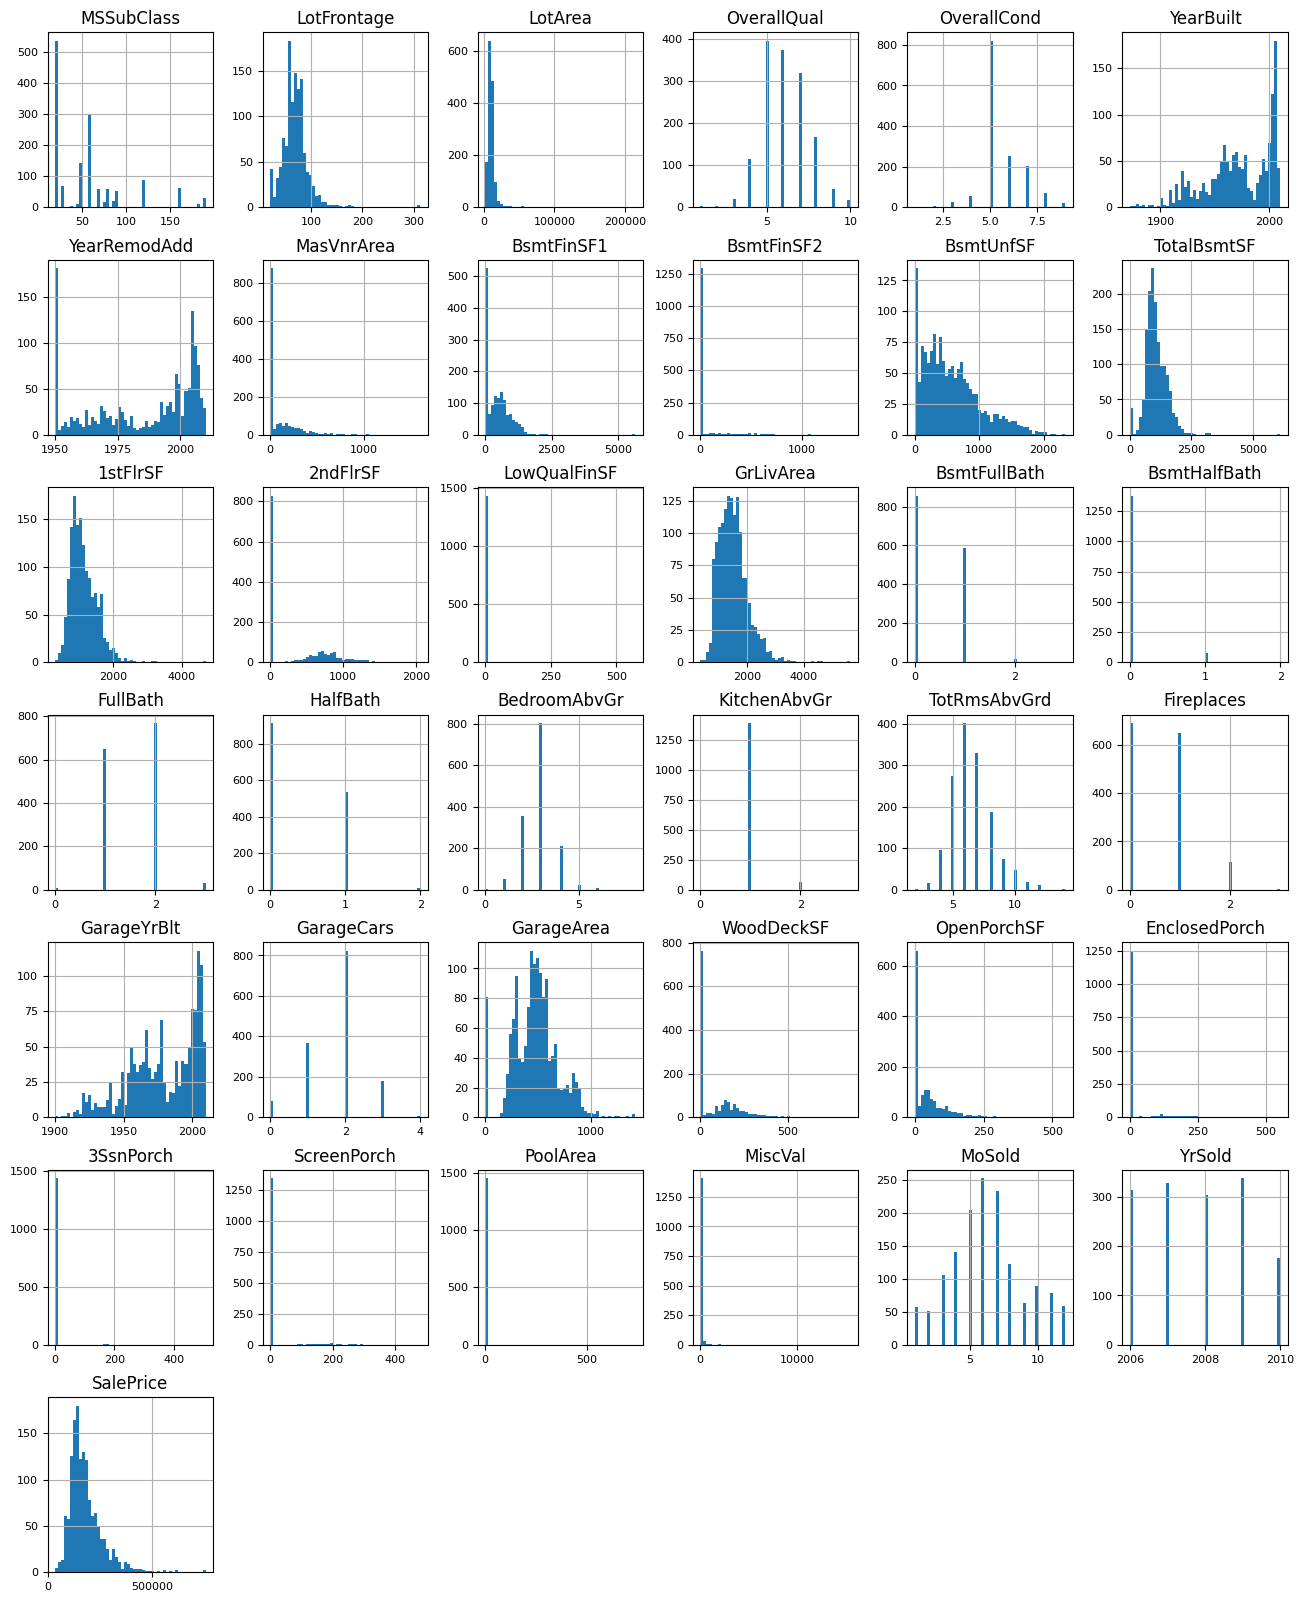

In [104]:
only_nums = eda_train.select_dtypes(include=["int64", "float64"])
only_nums.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Many numerical features are discrete. A lot of them have high frequency of 0 since eg not all houses have pools and such.

## Preprocessing

In [105]:
preprocessed_train_df = get_original_train_df()
na_counts = preprocessed_train_df.isna().sum()

print("Count of NA values in each column:")
print(na_counts)

Count of NA values in each column:
Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF           

Numerical absent values will be replaced with 0, while categorical will be replaced with string "NA" just like data description.

In [106]:
# preprocessed_train_df[categorical_columns].fillna("NA", inplace=True)
# preprocessed_train_df.fillna(0, inplace=True)

for column in preprocessed_train_df.columns:
    if preprocessed_train_df[column].dtype == 'object':  # Categorical data
        preprocessed_train_df[column].fillna('NA', inplace=True)
        
    elif preprocessed_train_df[column].dtype in ["int64", "float64"]:  # Numerical data
        preprocessed_train_df[column].fillna(0, inplace=True)

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_32409/367341955.py:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_32409/367341955.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

In [107]:
na_counts = preprocessed_train_df.isna().sum()

print("Count of NA values in each column:")
print(na_counts)

Count of NA values in each column:
Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath       

I'm gonna keep things simple for now and convert categorical features with label encoder since I don't think One-hot makes sense for most of these

In [108]:
preprocessed_train_df[categorical_columns].head(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [109]:
encoder = LabelEncoder()
for feat in categorical_columns:
    preprocessed_train_df[feat] = encoder.fit_transform(preprocessed_train_df[feat])

preprocessed_train_df[categorical_columns].head(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4


Using LabelEncoder is mostly suboptimal given that the model might misinterpret some features as having a sense of ordinality that they do not in fact have

## Linear Regression

In [110]:
X_r = preprocessed_train_df.copy().drop("SalePrice", axis=1, inplace=False)
y_r = preprocessed_train_df["SalePrice"].copy()
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.3, shuffle=True)

In [115]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_r, y_train_r)

LinearRegression()

In [122]:
y_pred_r = linear_reg.predict(X_test_r)
# score_lrmse_r = rmse_log(y_pred_r, y_test_r)
score_lrmse_r = root_mean_squared_log_error(y_test_r, y_pred_r)
score_rmse_r = root_mean_squared_error(y_test_r, y_pred_r)
print(f"Log RMSE: {score_lrmse_r}")
print(f"RMSE: {score_rmse_r}")

Log RMSE: 0.19825251031653215
RMSE: 52564.04056933526


### TODO: visualize pred vs true

In [ ]:
px.line()

## XGBoost

In [125]:
xgbr = XGBRegressor()
xgbr.fit(X_train_r, y_train_r)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [126]:
y_pred_xgbr = xgbr.predict(X_test_r)
score_lrmse_r = root_mean_squared_log_error(y_test_r, y_pred_xgbr)
score_rmse_r = root_mean_squared_error(y_test_r, y_pred_xgbr)
print(f"Log RMSE: {score_lrmse_r}")
print(f"RMSE: {score_rmse_r}")

Log RMSE: 0.15853063463275457
RMSE: 40459.81280188405


Baseline XGBRegressor has considerable error improvements over LinearRegressor. And that's with horrible feature selection and no tuning. Let's tune it

In [137]:
# hyperparameter search space
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform("n_estimators", 150, 250, 20),
    'seed': 0
}

# objective function that returns the score
def objective(space):
    clf=XGBRegressor(
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        eval_metric="rmse",
        early_stopping_rounds=10
    )
    
    evaluation = [(X_train_r, y_train_r), (X_test_r, y_test_r)]
    
    clf.fit(
        X_train_r, y_train_r,
        eval_set=evaluation, 
        verbose=True
    )
    

    pred = clf.predict(X_test_r)
    loss = root_mean_squared_error(y_test_r, pred)
    print ("SCORE:", loss)
    return {"loss": loss, "model": clf, "status": STATUS_OK}

trials = Trials()
best_hyperparams = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

def get_best_model_from_trials(trials):
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]

    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]

    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['model']

[0]	validation_0-rmse:61494.36160	validation_1-rmse:63087.64960                 
[1]	validation_0-rmse:48665.43566	validation_1-rmse:53576.88873                 
[2]	validation_0-rmse:39662.45024	validation_1-rmse:47134.16089                 
[3]	validation_0-rmse:33399.86920	validation_1-rmse:43430.20695                 
[4]	validation_0-rmse:28992.45154	validation_1-rmse:41900.88703                 
[5]	validation_0-rmse:25444.13419	validation_1-rmse:41044.25388                 
[6]	validation_0-rmse:22709.79790	validation_1-rmse:39873.25536                 
[7]	validation_0-rmse:20822.73813	validation_1-rmse:39894.46561                 
[8]	validation_0-rmse:19539.78478	validation_1-rmse:39655.87397                 
[9]	validation_0-rmse:18258.07997	validation_1-rmse:39911.54071                 
[10]	validation_0-rmse:17479.53972	validation_1-rmse:40168.17995                
[11]	validation_0-rmse:16761.63121	validation_1-rmse:40255.30101                
[12]	validation_0-rmse:16128

In [138]:
best_hyperparams

{'colsample_bytree': 0.6643006821281118,
 'gamma': 5.046639551015818,
 'max_depth': 8.0,
 'min_child_weight': 10.0,
 'n_estimators': 200.0,
 'reg_alpha': 169.0,
 'reg_lambda': 0.19315614432746064}

In [140]:
final_xgb = get_best_model_from_trials(trials)
# final_xgb.fit(X_train_r, y_train_r)
final_xgb_pred = final_xgb.predict(X_test_r)

score_lrmse_r = root_mean_squared_log_error(y_test_r, final_xgb_pred)
score_rmse_r = root_mean_squared_error(y_test_r, final_xgb_pred)
print(f"Log RMSE: {score_lrmse_r}")
print(f"RMSE: {score_rmse_r}")

Log RMSE: 0.15819023551591532
RMSE: 35877.763964335354


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

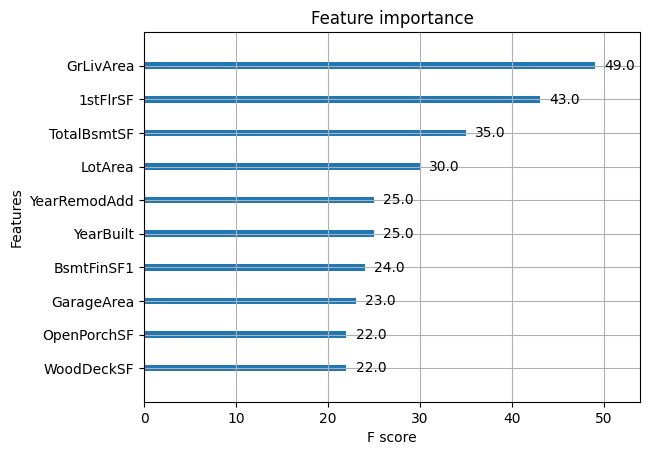

In [143]:
plot_importance(final_xgb, max_num_features=10)